In [1]:
from datasets import load_dataset

/Users/paperplanes/graphrag_yandex/for_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

## Предобработка датасета для создания графа

In [5]:
dataset = load_dataset("RussianNLP/wikiomnia",'wikiomnia_ruT5_raw')

In [10]:
len(dataset['test'])

267751

In [17]:
summaries = '\n\n'.join(dataset['test']['summary'][:3000])

In [18]:
with open('summaries.txt', 'w', encoding='utf-8') as f:
    f.write(summaries)
input_file = 'summaries.txt'  
output_file = 'input.txt'  
unique_lines = set()

with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        unique_lines.add(line.strip())  
with open(output_file, 'w', encoding='utf-8') as f:
    for line in unique_lines:
        f.write(line + '\n') 

## Анализ результатов

In [3]:
nodes1= pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/ragtest_new/output/create_final_nodes.parquet')
nodes1.community.values
coms = nodes1.community.values
counter= 0
for i in coms:
    if i:
        counter+=1
print(counter)

14


In [4]:
nodes1.degree.values

array([0, 0, 3, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 2, 4, 1, 1, 4, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 5, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 1, 1, 1, 0, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 3, 1, 4, 3, 2, 1, 1, 2, 1, 1, 2,
       2, 0, 1, 1, 1, 1, 1, 0, 0, 6, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 5, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 2, 1, 4, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2,
       2, 1, 3, 3, 1, 3, 1, 1, 1, 1])

In [6]:
nodes1.head(3)

,level,title,type,description,source_id,degree,human_readable_id,id,size,graph_embedding,community,entity_type,top_level_node_id,x,y
0,0,JESUS AND MARY CHAIN,ORGANIZATION,A band that reunited in 2007,e36a7efc3ca7af5e3dbecd7e88c9a10b,0,0,e738e74790f94e618b09c7f91ab7c04e,0,None,None,None,e738e74790f94e618b09c7f91ab7c04e,0,0
1,0,MAUENSEE,GEO,"A commune in Switzerland, in the canton of Luc...",e36a7efc3ca7af5e3dbecd7e88c9a10b,0,1,c3d5a134d6fa488bbb08e56c488f5042,0,None,None,None,c3d5a134d6fa488bbb08e56c488f5042,0,0
2,0,MOVSAR BARAYEV,PERSON,"Chechen field commander, terrorist, adherent o...",e36a7efc3ca7af5e3dbecd7e88c9a10b,3,2,46ad351bf215432fab9269cc0bd641ea,3,None,None,None,46ad351bf215432fab9269cc0bd641ea,0,0


In [7]:
nodes2 = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/graphrag/rag_bfs_modularity/output/create_final_nodes.parquet')

In [8]:
nodes3 = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/rag_threshold_modularity/output/create_final_nodes.parquet')

In [41]:
import pandas as pd
import networkx as nx
from networkx.algorithms.community import modularity

def calculate_graph_modularity(graph, community_attribute='community'):
    """
    Вычисляет модулярность графа с проверкой корректности разбиения.

    :param graph: NetworkX Graph
        Граф, для которого рассчитывается модулярность.
    :param community_attribute: str
        Название атрибута узла, по которому определяется сообщество.
    :return: float
        Модулярность графа.
    """
    all_nodes = set(graph.nodes)
    
    communities = {}
    for node, data in graph.nodes(data=True):
        community = data.get(community_attribute)
        if community is not None:
            communities.setdefault(community, []).append(node)
    
    partition = list(communities.values())

    partition_nodes = set(node for community in partition for node in community)
    
    if partition_nodes != all_nodes:
        missing_nodes = all_nodes - partition_nodes
        extra_nodes = partition_nodes - all_nodes
        
        if missing_nodes:
            #print(f"Добавляем недостающие узлы: {missing_nodes}")
            for node in missing_nodes:
                partition.append([node])
        
        if extra_nodes:
            print(f"Удаляем лишние узлы: {extra_nodes}")
            partition = [
                community for community in partition
                if not any(node in extra_nodes for node in community)
            ]

    modularity_score = modularity(graph, partition)
    return modularity_score

G = nx.Graph()

for _, row in nodes1.iterrows():
    G.add_node(row['id'], community=row['community'], type=row['type'], description=row['description'])

if 'source_id' in nodes1.columns:
    edges = nodes1[['source_id', 'id']].dropna()
    G.add_edges_from(edges.values)

modularity_score = calculate_graph_modularity(G)
print("Модулярность базового графа:", modularity_score)
G1= nx.Graph()

for _, row in nodes2.iterrows():
    G1.add_node(row['id'], community=row['community'], type=row['type'], description=row['description'])

if 'source_id' in nodes2.columns:
    edges1 = nodes2[['source_id', 'id']].dropna()
    G1.add_edges_from(edges1.values)

modularity_score1 = calculate_graph_modularity(G1)
print("Модулярность графа с bfs обходом узлов:", modularity_score1)
G2= nx.Graph()

for _, row in nodes3.iterrows():
    G2.add_node(row['id'], community=row['community'], type=row['type'], description=row['description'])

if 'source_id' in nodes3.columns:
    edges2 = nodes3[['source_id', 'id']].dropna()
    G2.add_edges_from(edges2.values)

modularity_score2 = calculate_graph_modularity(G2)
print("Модулярность графа с трешхолдом по модулярности:", modularity_score2)

Модулярность базового графа: -0.013180272108843514
Модулярность графа с bfs обходом узлов: -0.012505822679985545
Модулярность графа с трешхолдом по модулярности: -0.0021698390503772976


In [15]:
print('Количество ребер в обычном графе:',len(G.edges))
print('Количество ребер в графе с bfs обходом узлов',len(G1.edges))
print('Количество ребер в графе с трешхолдом по модулярности:',len(G2.edges))

Количество ребер в обычном графе: 252
Количество ребер в графе с bfs обходом узлов 278
Количество ребер в графе с трешхолдом по модулярности: 1552


In [51]:
g.nodes

NodeView(('JESUS AND MARY CHAIN', 'MAUENSEE', 'MOVSAR BARAYEV', 'ANGERBERG', 'VALENTIN KAMYSHOV', 'HARBACH', 'KARL KNORRE', 'MOSCOW', 'CHECHNYA', 'URGUEU', 'KERCH', 'CRIMEA', 'URAL STATE UNIVERSITY OF ECONOMICS', 'ARGUN', 'KARL FRIEDRICH KNORRE', 'KARLSBURG', 'BENDFELD', 'FESTIVAL DE GERARDMER – FANTASTIC’ARTS 5EME EDITION', 'ELENA NIKOLAEVNA CHAVCHAVADZE', 'USCH', 'BUILDING OF DESIGN ORGANIZATIONS', 'DESZCZNO', 'PRINCE ANDREW, DUKE OF YORK', 'PETERSBURG ACADEMY OF SCIENCES', 'MECKLENBURG-VORPOMMERN', 'SCHLESWIG-HOLSTEIN', 'VOSGES DEPARTMENT', 'RHINELAND-PALATINATE', 'ARKHANGELSK', 'GORZÓW COUNTY', 'LUBUSZ VOIVODESHIP', 'QUEEN ELIZABETH II', 'NIKOLAYEV MARINE OBSERVATORY', 'СУНЦ НГУ', 'НИКОЛАЙ КОНСТАНТИНОВИЧ МИХАЙЛОВСКИЙ', 'БУРГ', 'ФРАЙБУРГ', 'БАД-ЗОДЕН-ЗАЛЬМЮНСТЕР', 'ГРАН-ПРИ АВСТРАЛИИ 2002 ГОДА', 'ТОДД ДЖУЛИАН ФЕДОРЮК', 'ФИЛАДЕЛЬФИЯ ФЛАЙЕРЗ', 'АНАХАЙМ МАЙТИ ДАКС', 'САНКТ-ПЕТЕРБУРГ', 'КУЛЬМ', 'БУРГЕНЛАНД', 'УНСТРУТТАЛЬ', 'МАЙН-КИНЦИГ', 'АЛЬБЕРТ-ПАРК', 'МЕЛЬБУРН', 'РЕДУОТЕР', 'АЛЬБЕРТА

In [24]:
basic_report = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/ragtest_new/output/create_final_community_reports.parquet')
basic_report

,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,0,# Санкт-Петербург's Cultural and Musical Influ...,0,7.5,Санкт-Петербург's Cultural and Musical Influence,The impact severity rating is relatively high ...,"The community centers around Санкт-Петербург, ...",[{'explanation': 'Санкт-Петербург is not only ...,"{\n ""title"": ""Санкт-Петербург's Cultural an...",eaf65bb8-3933-42aa-a306-4533e32656aa
1,1,# Count Fedor Loginovich Heyden and Alexander ...,0,8.0,Count Fedor Loginovich Heyden and Alexander II,The impact severity rating is high due to the ...,This report focuses on the historical figures ...,[{'explanation': 'Count Fedor Loginovich Heyde...,"{\n ""title"": ""Count Fedor Loginovich Heyden...",bd082d7c-2ba1-43c1-adae-60f73c0e9d6f
2,2,# Intellectual and Cultural Dynamics in 19th C...,0,7.5,Intellectual and Cultural Dynamics in 19th Cen...,The impact severity rating is high due to the ...,This report explores the interconnected roles ...,[{'explanation': 'Dmitry Nikolaevich Bludov wa...,"{\n ""title"": ""Intellectual and Cultural Dyn...",d9381f08-f751-4d56-b35a-1c5901978bbf
3,3,# Nikolay Konstantinovich Mikhailovsky: A Pill...,0,7.5,Nikolay Konstantinovich Mikhailovsky: A Pillar...,The impact severity rating is relatively high ...,This report delves into the life and contribut...,[{'explanation': 'Nikolay Konstantinovich Mikh...,"{\n ""title"": ""Nikolay Konstantinovich Mikha...",69520b01-82ef-42cf-b261-f11a9c5fe035


In [27]:
bfs_report = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/ragtest_bfs/output/create_final_community_reports.parquet')
bfs_report

,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id,size,period
0,0,# Global Influence and Legacy of the ISU-122\n...,0,7.5,Global Influence and Legacy of the ISU-122,The impact severity rating is high due to the ...,"The ISU-122, a Soviet heavy self-propelled gun...",[{'explanation': 'The ISU-122 was not only a p...,"{\n ""title"": ""Global Influence and Legacy o...",a946ba53-5ec6-4ba7-91f6-27d81f755aec,1,2024-11-09


In [28]:
threshold_report = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/rag_threshold_modularity/output/create_final_community_reports.parquet')
threshold_report

,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id,size,period
0,10,# Mary Agard Pocock: A Legacy of Botanical Exp...,1,7.5,Mary Agard Pocock: A Legacy of Botanical Explo...,The impact severity rating is relatively high ...,This report explores the significant contribut...,[{'explanation': 'Mary Agard Pocock is renowne...,"{\n ""title"": ""Mary Agard Pocock: A Legacy o...",5b6b9fe0-3f3c-4ccb-8494-1ade9ae14433,1,2024-11-17
1,11,# USA and TransCanada: A Cross-Border Energy P...,1,7.5,USA and TransCanada: A Cross-Border Energy Par...,The impact severity rating is high due to the ...,This report explores the intricate relationshi...,[{'explanation': 'The United States of America...,"{\n ""title"": ""USA and TransCanada: A Cross-...",ad7e5091-107d-45dd-8390-934ec4b7ba5d,4,2024-11-17
2,12,# The Soviet Union: A Historical Overview of I...,1,8.5,The Soviet Union: A Historical Overview of Its...,The high impact severity rating reflects the p...,This report delves into the Soviet Union's (СС...,[{'explanation': 'The USSR's role as a primary...,"{\n ""title"": ""The Soviet Union: A Historica...",1bdb9a20-89f4-4091-91dc-1b455e9e8656,6,2024-11-17
3,13,# The Moscow Peace Treaty and Its Impact on Fi...,1,7.5,The Moscow Peace Treaty and Its Impact on Finland,The impact severity rating is high due to the ...,This report examines the historical context an...,[{'explanation': 'Finland lost 11% of its terr...,"{\n ""title"": ""The Moscow Peace Treaty and I...",b9517635-27ff-47df-a8b1-cdfd83944712,3,2024-11-17
4,0,# Influential Figures and Organizations in the...,0,8.5,Influential Figures and Organizations in the S...,The high impact severity rating reflects the p...,This report delves into the interconnected rol...,[{'explanation': 'The Communist Party of the S...,"{\n ""title"": ""Influential Figures and Organ...",114d12be-a89e-4172-bdb7-f75a2d186466,2,2024-11-17
5,1,# Rosneft's Arctic Operations: From Gdansk to ...,0,7.5,Rosneft's Arctic Operations: From Gdansk to th...,The impact severity rating is high due to the ...,This report outlines the operations and relati...,[{'explanation': 'Rosneft acquired a vessel in...,"{\n ""title"": ""Rosneft's Arctic Operations: ...",4028b51c-ecd2-4749-9446-2fab50f8f320,3,2024-11-17
6,2,"# Global Influence and Interconnections: USA, ...",0,7.5,"Global Influence and Interconnections: USA, Ma...",The impact severity rating is high due to the ...,This report explores the intricate relationshi...,[{'explanation': 'The United States of America...,"{\n ""title"": ""Global Influence and Intercon...",7d0febed-8474-4cee-8b24-51d3a51cac50,5,2024-11-17
7,3,# Checkpoint Charlie and the Cold War Divide\n...,0,8.5,Checkpoint Charlie and the Cold War Divide,The high impact severity rating reflects the s...,"Checkpoint Charlie, as a prominent crossing po...",[{'explanation': 'Checkpoint Charlie stood as ...,"{\n ""title"": ""Checkpoint Charlie and the Co...",84727cb5-bb6d-41f9-ab1c-19b9c57ed94b,2,2024-11-17
8,4,# Industrial Legacy of the Soviet Era: Magnito...,0,7.5,Industrial Legacy of the Soviet Era: Magnitogo...,The impact severity rating is high due to the ...,This report delves into the interconnectedness...,[{'explanation': 'Ivan Haritonovich Romazan st...,"{\n ""title"": ""Industrial Legacy of the Sovi...",cc9554e7-d9a8-4eb3-848a-3804462fbae0,2,2024-11-17
9,5,# Shane Mosley: A Champion's Roots in Californ...,0,4.0,Shane Mosley: A Champion's Roots in California,"The impact severity rating is moderate, reflec...",This report explores the community and network...,[{'explanation': 'Shane Mosley is recognized a...,"{\n ""title"": ""Shane Mosley: A Champion's Ro...",e15410fe-dd67-45d7-b184-d41e6485b2ba,1,2024-11-17


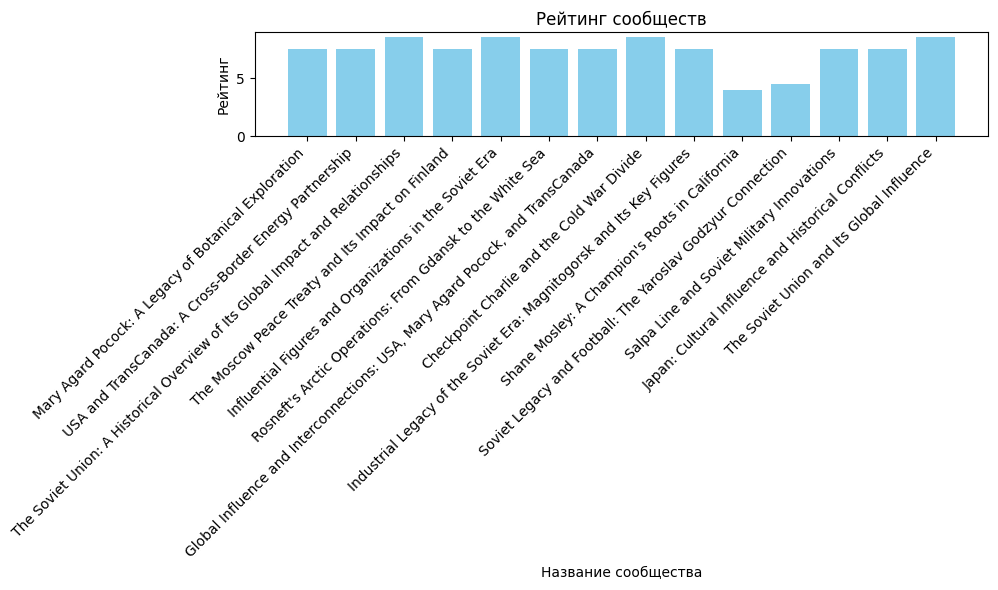

In [42]:
import matplotlib.pyplot as plt
df =threshold_report
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df['title'], df['rank'], color='skyblue')

ax.set_title('Рейтинг сообществ')
ax.set_xlabel('Название сообщества')
ax.set_ylabel('Рейтинг')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

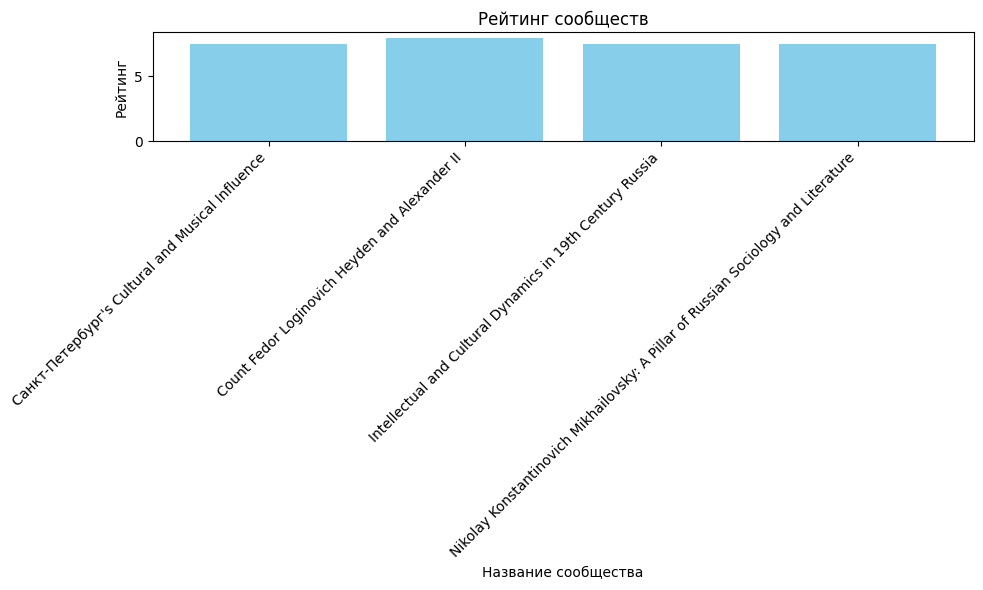

In [43]:
df = basic_report
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df['title'], df['rank'], color='skyblue')

ax.set_title('Рейтинг сообществ')
ax.set_xlabel('Название сообщества')
ax.set_ylabel('Рейтинг')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Создание сообществ (пример с методом с трешхолдом)

In [31]:
df = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/ragtest_new/output/create_base_extracted_entities.parquet')

In [32]:
df

,entity_graph
0,"<graphml xmlns=""http://graphml.graphdrawing.or..."


In [4]:
from graphrag.index.operations.cluster_graph import cluster_graph

/Users/paperplanes/graphrag_yandex/for_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
import logging
from enum import Enum
from random import Random
from tqdm import tqdm
import networkx as nx
import pandas as pd
from typing import Any, cast, List, Tuple, Dict
from graspologic.partition import hierarchical_leiden_new
from graspologic.partition import modularity
from graphrag.index.graph.utils import stable_largest_connected_component
from graphrag.index.utils import gen_uuid, load_graph

Communities = List[Tuple[int, str, List[str]]]

class GraphCommunityStrategyType(str, Enum):
    """GraphCommunityStrategyType class definition."""
    leiden = "leiden"

    def __repr__(self):
        return f'"{self.value}"'

log = logging.getLogger(__name__)

def cluster_graph(
    input_df: pd.DataFrame,
    callbacks: Any,  # VerbCallbacks
    strategy: Dict[str, Any],
    column: str,
    to: str,
    level_to: str | None = None,
) -> pd.DataFrame:
    """Apply a hierarchical clustering algorithm to a graph and compute modularity."""
    input_df["communities"] = input_df[column].apply(lambda graph: run_layout(strategy, graph))

    level_to = level_to or f"{to}_level"
    input_df[level_to] = input_df["communities"].apply(
        lambda x: list({level for level, _, _ in x})
    )
    input_df[to] = None

    seed = strategy.get("seed", Random().randint(0, 0xFFFFFFFF))  # noqa S311

    graph_level_pairs_column: List[List[Tuple[int, str]]] = []
    pbar = tqdm(total=len(input_df), mininterval=0.001)
    
    for _, row in input_df.iterrows():
        levels = row[level_to]
        graph_level_pairs = []

        for level in levels:
            graph_nx = apply_clustering(
                cast(str, row[column]),
                cast(Communities, row["communities"]),
                level,
                seed=seed,
            )

            # Ensure all nodes have a cluster assignment
            unclustered_nodes = [node for node, data in graph_nx.nodes(data=True) if "cluster" not in data]
            if unclustered_nodes:
                default_cluster_id = "-1"  # Assign a default cluster for unclustered nodes
                for node in unclustered_nodes:
                    graph_nx.nodes[node]["cluster"] = default_cluster_id
                    graph_nx.nodes[node]["level"] = level

            try:
                modularity = nx.algorithms.community.modularity(
                    graph_nx, [list(n for n, d in graph_nx.nodes(data=True) if d["cluster"] == c) for c in set(nx.get_node_attributes(graph_nx, "cluster").values())]
                )
                print(f"Modularity for level {level}: {modularity}")
            except Exception as e:
                log.warning(f"Failed to compute modularity for level {level}: {e}")

            graph_str = "\n".join(nx.generate_graphml(graph_nx))
            graph_level_pairs.append((level, graph_str))
        
        graph_level_pairs_column.append(graph_level_pairs)
        pbar.update(1)

    pbar.close()
    input_df[to] = graph_level_pairs_column
    input_df = input_df.explode(to, ignore_index=True)
    input_df[[level_to, to]] = pd.DataFrame(input_df[to].tolist(), index=input_df.index)
    input_df.drop(columns=["communities"], inplace=True)

    return input_df

def apply_clustering(
    graphml: str, communities: Communities, level: int = 0, seed: int | None = None
) -> nx.Graph:
    """Apply clustering to a graphml string and return the modified graph."""
    random = Random(seed)  # noqa S311
    graph = nx.parse_graphml(graphml)

    for community_level, community_id, nodes in communities:
        if level == community_level:
            for node in nodes:
                if node in graph:
                    graph.nodes[node]["cluster"] = community_id
                    graph.nodes[node]["level"] = level

    for index, node in enumerate(graph.nodes()):
        graph.nodes[node]["human_readable_id"] = index
        graph.nodes[node]["id"] = str(gen_uuid(random))

    for index, edge in enumerate(graph.edges()):
        graph.edges[edge]["id"] = str(gen_uuid(random))
        graph.edges[edge]["human_readable_id"] = index
        graph.edges[edge]["level"] = level

    return graph

def run_layout(
    strategy: Dict[str, Any], graphml_or_graph: str | nx.Graph
) -> Communities:
    """Run a layout algorithm and return a list of communities."""
    graph = load_graph(graphml_or_graph)
    if len(graph.nodes) == 0:
        log.warning("Graph has no nodes")
        return []

    strategy_type = strategy.get("type", GraphCommunityStrategyType.leiden)
    clusters = {}

    if strategy_type == GraphCommunityStrategyType.leiden:
        clusters = run_leiden(graph, strategy)
    else:
        raise ValueError(f"Unknown clustering strategy {strategy_type}")

    results = []
    for level, cluster_data in clusters.items():
        for cluster_id, nodes in cluster_data.items():
            results.append((level, cluster_id, nodes))
    
    return results

def run_leiden(
    graph: nx.Graph, args: Dict[str, Any]
) -> Dict[int, Dict[str, List[str]]]:
    """Run the Leiden algorithm and return communities by level."""
    max_cluster_size = args.get("max_cluster_size", 10)
    use_lcc = args.get("use_lcc", True)
    print('graph:',graph)
    if use_lcc:
        graph = stable_largest_connected_component(graph)

    community_mapping = hierarchical_leiden_new(
        graph, max_cluster_size=max_cluster_size, random_seed=args.get("seed", 0xDEADBEEF)
    )
    
    results = {}
    for partition in community_mapping:
        results.setdefault(partition.level, {})[partition.node] = partition.cluster
    print('graph:',graph)
    print('comms:',results)
    print(modularity(graph,results[0]))
    cluster_data = {
        level: {
            str(cluster): [node for node, cluster_id in partition_data.items() if cluster_id == int(cluster)]
            for cluster in set(partition_data.values())
        }
        for level, partition_data in results.items()
    }
    
    return cluster_data


In [34]:
# from cluster_graph_n import _compute_leiden_communities
from datashaper import (
    VerbCallbacks,
)
strategy = {
    "type": "leiden",  # Используем стратегию Лейдена
    "seed": 42,        # Задаём начальное значение для воспроизводимости
    "max_cluster_size": 10  # Максимальный размер кластера
}

result_df =cluster_graph(
    input_df=df,
    callbacks = VerbCallbacks,
    strategy=strategy,
    column='entity_graph',  # Имя колонки с графом
    to='clustered_entity_graphs'
)

graph: Graph with 252 nodes and 107 edges
graph: Graph with 14 nodes and 13 edges
comms: {0: {'KITCHEN RECORDS': 0, 'KREC': 0, 'АРТЁМ «FUZE» БРОВКОВ': 0, 'САНКТ-ПЕТЕРБУРГ': 0, 'НИКОЛАЙ КОНСТАНТИНОВИЧ МИХАЙЛОВСКИЙ': 1, 'МЕЩОВСК': 1, 'ФЁДОР ЛОГИНОВИЧ ГЕЙДЕН': 2, 'АЛЕКСАНДР II': 2, 'ДМИТРИЙ НИКОЛАЕВИЧ БЛУДОВ': 3, 'ПЕТЕРБУРГСКАЯ АКАДЕМИЯ НАУК': 3, 'АРЗАМАС': 3, 'ЛЕОПОЛЬД ФОН РАНКЕ': 3, 'ПРУССКАЯ АКАДЕМИЯ НАУК': 3, 'ФРАНЦУЗСКАЯ АКАДЕМИЯ МОРАЛЬНЫХ И ПОЛИТИЧЕСКИХ НАУК': 3}}
0.4418533760097546


100%|██████████| 1/1 [00:00<00:00, 36.77it/s]

Modularity for level 0: 0.2036604873209745


In [35]:
# from cluster_graph_n import _compute_leiden_communities
from datashaper import (
    VerbCallbacks,
)
strategy = {
    "type": "leiden",  # Используем стратегию Лейдена
    "seed": 42,        # Задаём начальное значение для воспроизводимости
    "max_cluster_size": 10  # Максимальный размер кластера
}

result_df = cluster_graph(
    input_df=df,
    callbacks = VerbCallbacks,
    strategy=strategy,
    column='entity_graph',  # Имя колонки с графом
    to='clustered_entity_graphs'
)

graph: Graph with 252 nodes and 107 edges
graph: Graph with 14 nodes and 13 edges
comms: {0: {'KITCHEN RECORDS': 0, 'KREC': 0, 'АРТЁМ «FUZE» БРОВКОВ': 0, 'САНКТ-ПЕТЕРБУРГ': 0, 'НИКОЛАЙ КОНСТАНТИНОВИЧ МИХАЙЛОВСКИЙ': 1, 'МЕЩОВСК': 1, 'ФЁДОР ЛОГИНОВИЧ ГЕЙДЕН': 2, 'АЛЕКСАНДР II': 2, 'ДМИТРИЙ НИКОЛАЕВИЧ БЛУДОВ': 3, 'ПЕТЕРБУРГСКАЯ АКАДЕМИЯ НАУК': 3, 'АРЗАМАС': 3, 'ЛЕОПОЛЬД ФОН РАНКЕ': 3, 'ПРУССКАЯ АКАДЕМИЯ НАУК': 3, 'ФРАНЦУЗСКАЯ АКАДЕМИЯ МОРАЛЬНЫХ И ПОЛИТИЧЕСКИХ НАУК': 3}}
0.4418533760097546


100%|██████████| 1/1 [00:00<00:00, 43.78it/s]

Modularity for level 0: 0.2036604873209745


In [36]:
from unpack_graph import unpack_graph
from datashaper import (
    VerbCallbacks,
)
ent_df = unpack_graph(input_df = result_df,
                      callbacks = VerbCallbacks,
                      column = 'clustered_entity_graphs',
                      type = 'nodes')

100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


In [37]:
chunks = pd.read_parquet('/Users/paperplanes/graphrag_yandex/graphrag/ragtest_new/output/create_base_text_units.parquet')

In [39]:
chunks.chunk[0]

'\nStarNet — одна из крупнейших телекоммуникационных компаний в Молдавии. Оказывает услуги интернета, фиксированной телефонии NGN, цифрового телевидения, хостинга, виртуальной частной сети, услуги по установке оборудования. Оператор является вторым по величине (после Moldtelecom) интернет-провайдером в стране. Изначально предоставлял услуги в Кишинёве, затем география предоставления услуг расширилась на Бельцы, Унгены, Оргеев, Ставчены, Кахул. С 24 ноября 2011 года стал предоставлять услуги по всей стране.В 2012 году планирует запустить систему электронной оплаты «StarWallet» в сотрудничестве с компанией en:Coinstar.Компания имеет разрешение от НАРЭКИТ (одна из трёх в стране) на осуществление деятельности по эксплуатации, управлению и поддержке сетей электронных коммуникаций на государственной границе Республики Молдова с Румынией.\nПайен (ум. 1148) — барон Иерусалимского королевства, сеньор Трансиордании. В 1120 году впервые упоминается как королевский дворецкий и занимал эту должност